# Disaster Tweets

# Problem Statement

* blah blah

# Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd 
import os 

import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [3]:
df_train=pd.read_csv(r"/kaggle/input/nlp-getting-started/train.csv")

In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_train.shape

(7613, 5)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


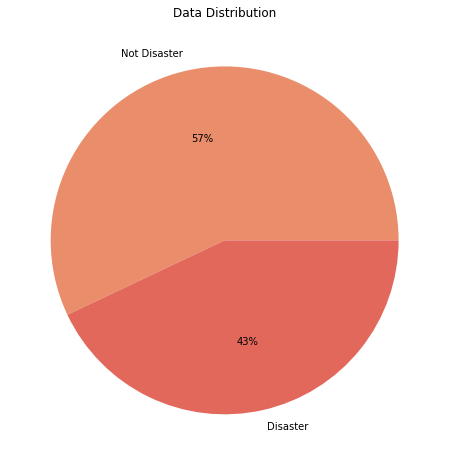

In [7]:
plt.figure(figsize=(8,8))
colors = sns.color_palette('flare')
plt.pie(x=df_train["target"].value_counts().values,labels=["Not Disaster", "Disaster"],autopct='%.0f%%', colors=colors)
plt.title("Data Distribution")
plt.show()

* The data doesn't seem to be awfully misbalanced
* Both of the classes have an _almost_ equal distribution. So we don't need to worry about creating a balanced dataset by either subsampling the data or some other data augmentation technique.

#### Handling Missing Values

In [8]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
df_train.isnull().sum() / len(df_train) * 100

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

- `keyword` column is missing less than 1% values
- `location` column is missing more. than 33% of its values

There are multiple solutions on handling this situation. For now,
- I'll be dropping the `location` column altogether since keeping it in might throw-off the model. It could potentially take _absense_ of location keyword as an important factor for a disaster or a not disaster tweet.
- For the `keyword` column, we can drop the rows with null values in them since our dataset is relatively huge.

In [10]:
df_train = df_train.drop(columns=['location'])

In [11]:
df_train = df_train.dropna(subset=['keyword'])

In [12]:
df_train.shape

(7552, 4)

- As expected, the number of rows in training dataset drops from 7613 to 7552. 
- This is not a huge drop, we can continue on with our analysis

#### Keywords

In [13]:
keyword_distribution = df_train['keyword'].value_counts()
keyword_distribution[:10]

fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
Name: keyword, dtype: int64

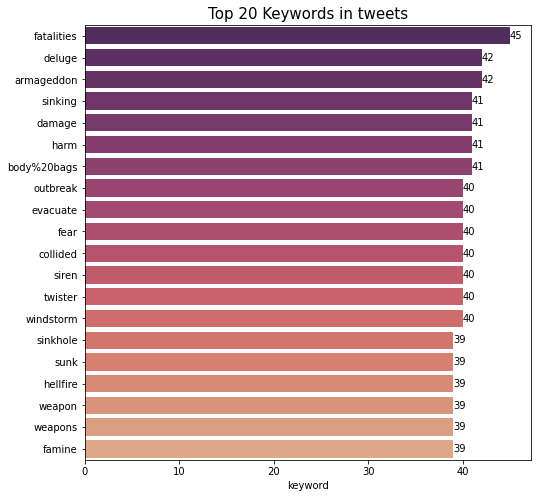

In [14]:
plt.figure(figsize=(8,8))

top_20_keywords=df_train['keyword'].value_counts()[:20]
ax = sns.barplot(y=top_20_keywords.index,x=top_20_keywords,palette='flare_r',data=df_train)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Top 20 Keywords in tweets',fontsize=15)
plt.show()

#### Keywords - Disaster vs Not Disaster

In [15]:
keywords_disaster = df_train.loc[df_train["target"] == 1]["keyword"].value_counts()
keywords_not_disaster = df_train.loc[df_train["target"] == 0]["keyword"].value_counts()

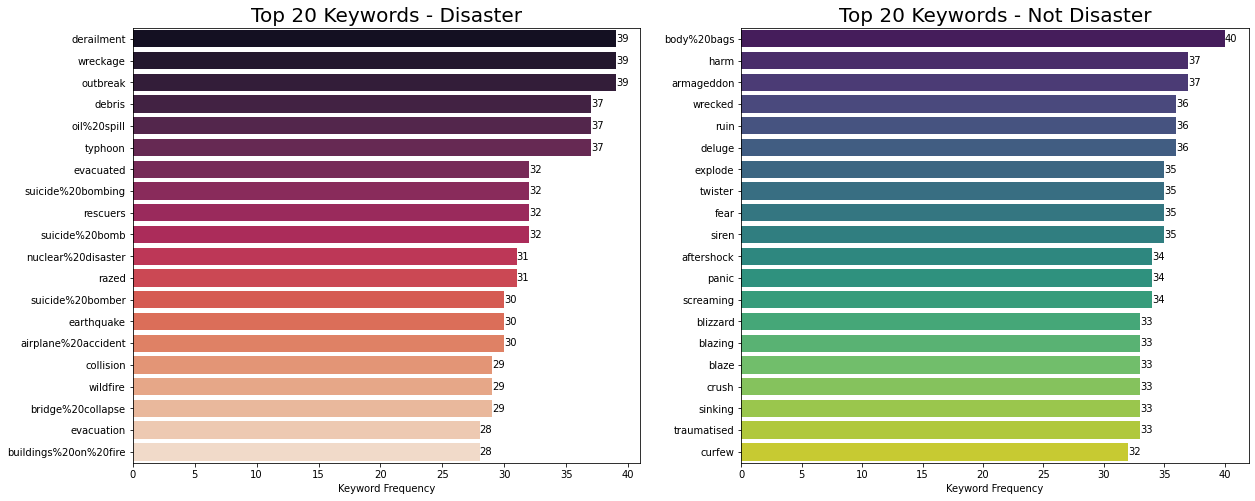

In [16]:
# plt.figure(figsize=(20,8))
fig, ax = plt.subplots(1,2, figsize=(20,8))

ax1 = sns.barplot(y=keywords_disaster[0:20].index, x=keywords_disaster[0:20], orient='h', ax=ax[0], palette="rocket")
for container in ax1.containers:
    ax1.bar_label(container)
ax[0].set_title("Top 20 Keywords - Disaster",fontsize=20)
ax[0].set_xlabel("Keyword Frequency")

ax2 = sns.barplot(y=keywords_not_disaster[0:20].index, x= keywords_not_disaster[0:20], orient='h', ax=ax[1], palette="viridis")
for container in ax2.containers:
    ax2.bar_label(container)
ax[1].set_title("Top 20 Keywords - Not Disaster",fontsize=20)
ax[1].set_xlabel("Keyword Frequency")


plt.show()

#### Tweet Length and Word Counts

* Twitter has traditionally always had a hard limit of 140 character for tweets. Only a few years ago did they double the limit to 280.

In [17]:
df_train["length"] = df_train["text"].str.len()
df_train["word_count"] = df_train["text"].apply(lambda x: len(x.split()))

In [18]:
df_train.head()

,id,keyword,text,target,length,word_count
31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55,5
32,49,ablaze,We always try to bring the heavy. #metal #RT h...,0,67,10
33,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82,9
34,52,ablaze,Crying out for more! Set me ablaze,0,34,7
35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76,13


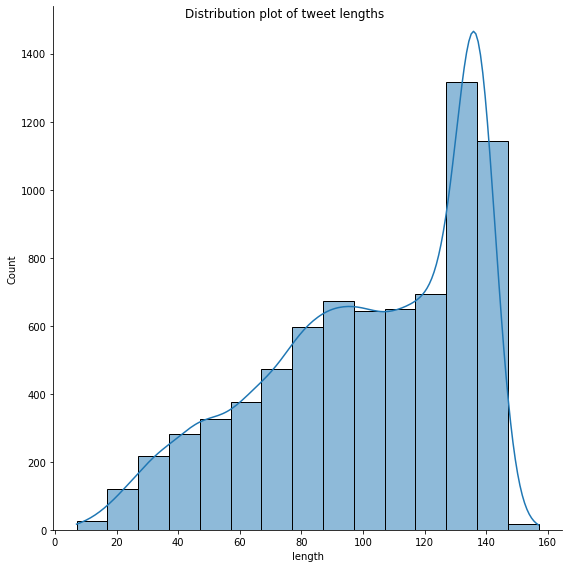

In [19]:
ax = sns.displot(df_train["length"],bins=15,kde=True, height=8)
ax.fig.suptitle('Distribution plot of tweet lengths')
plt.show()

In [20]:
df_train['length'].describe()

count    7552.000000
mean      101.256488
std        33.579745
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

* Average tweet length is 101 characters
* Longest tweet is 157 characters long

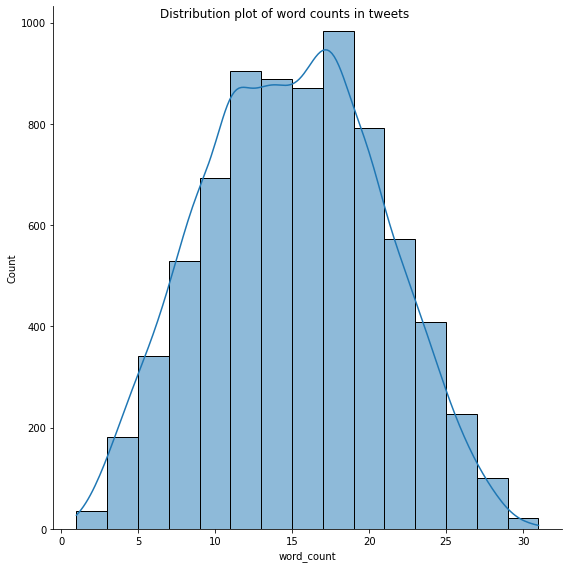

In [21]:
ax = sns.displot(df_train["word_count"],bins=15,kde=True, height=8)
ax.fig.suptitle('Distribution plot of word counts in tweets')
plt.show()

In [22]:
df_train['word_count'].describe()

count    7552.000000
mean       14.931806
std         5.715034
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: word_count, dtype: float64

* Average number of words per tweet is approx 15
* Max number of words per tweet is 31

### Preprocessing text for a ML Model

Cleanup process:
- Remove stopwords (from `nltk` library)
- Remove punctuations
- Since we're dealing with raw tweets data, we'll also remove any emojis using `regex`
- Apply a stemming algorithm (`Porter` from `nltk` library)
- Perform TF-IDF vectorization

What is stemming?
- Stemming is the process of reducing variants to a root word
- For example: chocolates, chocolatey, choco can all be reduced to the same root word - `chocolate`

What is TF-IDF?
- TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency.
- It converts text into meaningful representation of numbers which is used to fit ML algorithms for prediction.

In [23]:
nltk_stopwords = stopwords.words('english')

def remove_stopwords(row):
    # convert the whole tweet to lowercase
    text = row.lower()
    
    # keep only alphabets
    # remove punctuations, numbers
    text = re.sub('[^a-z]', ' ', text)
    
    # remove emojis
    # code for removing emojis from - https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
    emoji_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    text = emoji_pattern.sub(r'',text)
    
    # split out the tweet into a list
    # ex: "hello world !" -> ["hello", "world", "!"]
    text = text.split()
    
    # remove stopwords
    text = [word for word in text if word not in nltk_stopwords]
    
    return ' '.join(text)

In [24]:
# let's test the function with "Hello world is the ! \U0001f602" 
# \U0001f602 is the smiling emoji
# these 3 items should be removed: is, the, !, \U0001f602
remove_stopwords("hello world is the ! \U0001f602")

'hello world'

In [25]:
df_train["clean_text"] = df_train["text"].apply(remove_stopwords)

In [26]:
df_train.head()

,id,keyword,text,target,length,word_count,clean_text
31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55,5,bbcmtd wholesale markets ablaze http co lhyxeo...
32,49,ablaze,We always try to bring the heavy. #metal #RT h...,0,67,10,always try bring heavy metal rt http co yao e ...
33,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82,9,africanbaze breaking news nigeria flag set abl...
34,52,ablaze,Crying out for more! Set me ablaze,0,34,7,crying set ablaze
35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76,13,plus side look sky last night ablaze http co q...


In [27]:
port_stem = PorterStemmer()

def port_stemmer(row):
    text = row.split()
    
    text = [port_stem.stem(word) for word in text]
    
    return ' '.join(text)

In [28]:
df_train["clean_stemmed_text"] = df_train["clean_text"].apply(port_stemmer)

In [29]:
df_train.head()

,id,keyword,text,target,length,word_count,clean_text,clean_stemmed_text
31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55,5,bbcmtd wholesale markets ablaze http co lhyxeo...,bbcmtd wholesal market ablaz http co lhyxeohi c
32,49,ablaze,We always try to bring the heavy. #metal #RT h...,0,67,10,always try bring heavy metal rt http co yao e ...,alway tri bring heavi metal rt http co yao e xngw
33,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82,9,africanbaze breaking news nigeria flag set abl...,africanbaz break news nigeria flag set ablaz a...
34,52,ablaze,Crying out for more! Set me ablaze,0,34,7,crying set ablaze,cri set ablaz
35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76,13,plus side look sky last night ablaze http co q...,plu side look sky last night ablaz http co qqs...


#### Convert the cleaned text data into one hot embeddings

In [30]:
one_hot_list = [one_hot(row, 5000) for row in df_train["clean_stemmed_text"].values]

In [31]:
df_train["clean_stemmed_text"].values[0]

'bbcmtd wholesal market ablaz http co lhyxeohi c'

In [32]:
one_hot_list[0]

[1981, 6, 672, 2413, 1087, 4489, 2246, 1964]

In [33]:
embedded_docs = pad_sequences(one_hot_list, padding='pre', maxlen=31)

# Model Architecture

#### Split the data into train & validation sets

In [34]:
# X = df_vec.drop("target", axis=1)
X = np.array(embedded_docs)
y = np.array(df_train["target"])

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

In [35]:
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

((5664, 31), (5664,), (1888, 31), (1888,))

#### Train the ML Model

What is an embedding layer?
- Embedding layer converts the input integer indices into corresponding word vectors. Word embedding is a way of representing a word as a vector. After training, words with similar meanings often have similar vectors

What is a LSTM layer?
- Long Short-Term Memory Layer based on a paper by Hochreiter published in 1997. LSTM layers learn long-term dependencies between time steps in sequence data. 

What is a dropout layer?
- Dropout layer randomly sets inputs to 0 during training to prevent overfitting.

What is a dense layer?
- Dense layer is a simple layer of neurons which receives input from all the neurons of the previous layer. In our model, we'll be using Dense layer as our output layer with a `sigmoid` activation since we're solving a binary classification problem.

In [36]:
# model = Sequential()

# model.add(Embedding(5001, 40, input_length=31))
# model.add(Dropout(0.2))
# model.add(LSTM(256, dropout=0.2))
# model.add(Dense(1, activation='sigmoid'))
# opt = tf.keras.optimizers.Adam(0.001)
# model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [37]:
# model.summary()

In [38]:
# history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_validation, y_validation))

In [39]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model One Accuracy per Epoch')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validate'], loc='upper left')
# plt.show();

# # plot model loss per epoch
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model One Loss per Epoch')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validate'], loc='upper left')
# plt.show();

- The accuracy for`validation` set goes down sharply as # of epochs go up.
- We can try the following next
    - Add `EarlyStopping` callback function to stop training if validation accuracy goes down for multiple epochs
    - Add `ReduceLROnPlateau` callback function to reduce learning rate if validation accuracy pleataus 
    - Increase the # of LSTM layers
    - Add more cells in each LSTM layer
- The model might be overfitting since `train_acc` increases but `val_acc` decreases with an increase in # of epochs. Potential fixes:
    - Add more dropout layers
    - Reduce the learning rate
    

In [40]:
model2 = Sequential()

model2.add(Embedding(5001, 40, input_length=31))
# model2.add(Dropout(0.1))
# model2.add(Bidirectional(LSTM(256, return_sequences=True)))
model2.add(Dropout(0.5))
model2.add(LSTM(256, return_sequences=True))
model2.add(Dropout(0.50))
# model2.add(Bidirectional(LSTM(400, return_sequences=True)))
# model2.add(Dropout(0.25))
model2.add(LSTM(256))
model2.add(Dropout(0.50))
# model2.add(Dense(100, activation='relu'))
# model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(1e-4)
model2.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

2022-09-28 21:40:07.124846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 21:40:07.216900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 21:40:07.217706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 21:40:07.218864: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [41]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 31, 40)            200040    
_________________________________________________________________
dropout (Dropout)            (None, 31, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 31, 256)           304128    
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2

In [42]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=1e-6)

                              
callbacks_list = [early_stop, reduce_lr]

In [43]:
# history2 = model2.fit(X_train, y_train, epochs=40, batch_size=128, validation_data=(X_validation, y_validation), callbacks=callbacks_list)
history2 = model2.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_validation, y_validation))

Epoch 1/40


2022-09-28 21:40:10.653633: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-28 21:40:13.734532: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


177/177 [==============================] - 6s 12ms/step - loss: 0.6663 - accuracy: 0.5856 - val_loss: 0.6424 - val_accuracy: 0.6075
Epoch 2/40
177/177 [==============================] - 1s 8ms/step - loss: 0.6193 - accuracy: 0.6536 - val_loss: 0.5958 - val_accuracy: 0.6774
Epoch 3/40
177/177 [==============================] - 1s 8ms/step - loss: 0.5258 - accuracy: 0.7463 - val_loss: 0.4829 - val_accuracy: 0.7733
Epoch 4/40
177/177 [==============================] - 1s 8ms/step - loss: 0.4313 - accuracy: 0.8058 - val_loss: 0.4725 - val_accuracy: 0.7749
Epoch 5/40
177/177 [==============================] - 1s 8ms/step - loss: 0.3978 - accuracy: 0.8236 - val_loss: 0.4723 - val_accuracy: 0.7807
Epoch 6/40
177/177 [==============================] - 2s 9ms/step - loss: 0.3701 - accuracy: 0.8430 - val_loss: 0.4857 - val_accuracy: 0.7855
Epoch 7/40
177/177 [==============================] - 1s 8ms/step - loss: 0.3445 - accuracy: 0.8565 - val_loss: 0.4965 - val_accuracy: 0.7855
Epoch 8/40
177/1

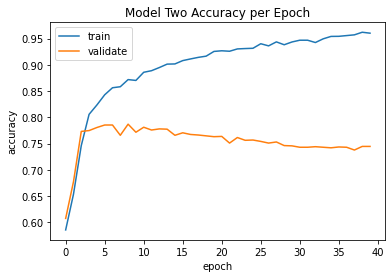

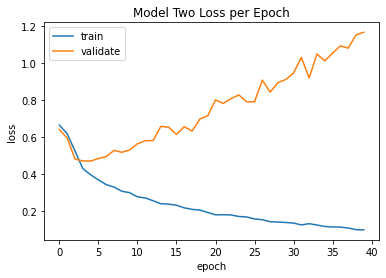

In [44]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Two Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model loss per epoch
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Two Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

- The model has improved marginally
- But the gap between the first graph of each model has reduced signficantly.
    - We've succesfully reduced overfitting thereby making the model more generalizable

### Hyperparamter tuning

### Generate predictions for test set

- We will load the test dataset and perform the same text pre-processing as done for training dataset
- We will use the **best** model trained above to generate predictions

In [45]:
df_test = pd.read_csv(r"/kaggle/input/nlp-getting-started/test.csv")
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


- Since we only used `text` column as input for our model, we can drop the other columns
- We need to keep the id column for generating `sample_submission.csv`

In [46]:
df_test = df_test.drop(columns=['keyword', 'location'])
df_test.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [47]:
df_test["clean_text"] = df_test["text"].apply(remove_stopwords)
df_test["clean_stemmed_text"] = df_test["clean_text"].apply(port_stemmer)
test_one_hot_list = [one_hot(row, 5000) for row in df_test["clean_stemmed_text"].values]
test_embedded_docs = pad_sequences(test_one_hot_list, padding='pre', maxlen=31)

X_test = np.array(test_embedded_docs)

In [48]:
preds = model2.predict(X_test)
preds = [0 if pred < 0.5 else 1 for pred in preds]
preds[:10]

[1, 1, 1, 0, 1, 0, 0, 0, 0, 0]

In [49]:
df_test["target"] = preds
df_test.head()

,id,text,clean_text,clean_stemmed_text,target
0,0,Just happened a terrible car crash,happened terrible car crash,happen terribl car crash,1
1,2,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...,heard earthquak differ citi stay safe everyon,1
2,3,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...,forest fire spot pond gees flee across street ...,1
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,apocalyps light spokan wildfir,0
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan,typhoon soudelor kill china taiwan,1


In [50]:
df_test[["id", "target"]]

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [51]:
df_test[["id", "target"]].to_csv("submission.csv", index=False)

# Conclusion